In [1]:
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import json
import requests
from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import geocoder
import time
import folium 

In [21]:
!pip install geopy

You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [22]:
!pip install folium

You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [16]:
import geopy

In [19]:
!pip install geocoder

You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [25]:
wikipedia_link = 'https://en.wikipedia.org/wiki/List_of_areas_of_London'
wikipedia_page = requests.get(wikipedia_link, headers = None)

In [26]:
soup = BeautifulSoup(wikipedia_page.content, 'html.parser')
table = soup.find('table', {'class':'wikitable sortable'}).tbody

In [27]:
rows = table.find_all('tr')

In [28]:
columns = ['Location','London borough','Post town','Postcode district','Dial code','OS grid ref']

In [29]:
df = pd.DataFrame(columns = columns)
df

,Location,London borough,Post town,Postcode district,Dial code,OS grid ref


In [30]:
for i in range(1, len(rows)):
    tds = rows[i].find_all('td')
    

    if len(tds) == 7:
        values = [tds[0].text, tds[1].text, tds[2].text, tds[3].text, tds[4].text, tds[5].text, tds[6].text]
    else:
        values = [td.text for td in tds]
        df = df.append(pd.Series(values, index = columns), ignore_index = True)
        df

In [31]:
df.head()

,Location,London borough,Post town,Postcode district,Dial code,OS grid ref
0,Abbey Wood,"Bexley, Greenwich [7]",LONDON,SE2,020,TQ465785\n
1,Acton,"Ealing, Hammersmith and Fulham[8]",LONDON,"W3, W4",020,TQ205805\n
2,Addington,Croydon[8],CROYDON,CR0,020,TQ375645\n
3,Addiscombe,Croydon[8],CROYDON,CR0,020,TQ345665\n
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,TQ478728\n


In [32]:
df = df.rename(index=str, columns = {'Location': 'Location', 'London borough': 'Borough', 'Post town': 'Post-town', 'Postcode district': 'Postcode', 'Dial code': 'Dial-code', 'OS grid ref': 'OSGridRef'})

In [33]:
df.head(5)

,Location,Borough,Post-town,Postcode,Dial-code,OSGridRef
0,Abbey Wood,"Bexley, Greenwich [7]",LONDON,SE2,020,TQ465785\n
1,Acton,"Ealing, Hammersmith and Fulham[8]",LONDON,"W3, W4",020,TQ205805\n
2,Addington,Croydon[8],CROYDON,CR0,020,TQ375645\n
3,Addiscombe,Croydon[8],CROYDON,CR0,020,TQ345665\n
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,TQ478728\n


In [34]:
df['Borough'] = df['Borough'].map(lambda x: x.rstrip(']').rstrip('0123456789').rstrip('['))

In [35]:
df.head()

,Location,Borough,Post-town,Postcode,Dial-code,OSGridRef
0,Abbey Wood,"Bexley, Greenwich",LONDON,SE2,020,TQ465785\n
1,Acton,"Ealing, Hammersmith and Fulham",LONDON,"W3, W4",020,TQ205805\n
2,Addington,Croydon,CROYDON,CR0,020,TQ375645\n
3,Addiscombe,Croydon,CROYDON,CR0,020,TQ345665\n
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,TQ478728\n


In [36]:
df0 = df.drop('Postcode', axis=1).join(df['Postcode'].str.split(',', expand=True).stack().reset_index(level=1, drop=True).rename('Postcode'))

In [37]:
df0.head()

,Location,Borough,Post-town,Dial-code,OSGridRef,Postcode
0,Abbey Wood,"Bexley, Greenwich",LONDON,020,TQ465785\n,SE2
1,Acton,"Ealing, Hammersmith and Fulham",LONDON,020,TQ205805\n,W3
1,Acton,"Ealing, Hammersmith and Fulham",LONDON,020,TQ205805\n,W4
10,Angel,Islington,LONDON,020,TQ345665\n,EC1
10,Angel,Islington,LONDON,020,TQ345665\n,N1


In [38]:
df0.shape

(638, 6)

In [39]:
df1 = df0[['Location','Borough','Postcode','Post-town']].reset_index(drop=True)

In [40]:
df1.head(10)

,Location,Borough,Postcode,Post-town
0,Abbey Wood,"Bexley, Greenwich",SE2,LONDON
1,Acton,"Ealing, Hammersmith and Fulham",W3,LONDON
2,Acton,"Ealing, Hammersmith and Fulham",W4,LONDON
3,Angel,Islington,EC1,LONDON
4,Angel,Islington,N1,LONDON
5,Church End,Brent,NW10,LONDON
6,Church End,Barnet,N3,LONDON
7,Clapham,"Lambeth, Wandsworth",SW4,LONDON
8,Clerkenwell,Islington,EC1,LONDON
9,Cockfosters,"Barnet, Enfield",EN4,BARNET


In [41]:
df1.shape

(638, 4)

In [42]:
df2 = df1
df2 = df2[df2['Post-town'].str.contains('LONDON')]

In [43]:
df2.shape

(382, 4)

In [44]:
df3 = df2[['Location','Borough','Postcode']].reset_index(drop=True)

In [45]:
df3.head()

,Location,Borough,Postcode
0,Abbey Wood,"Bexley, Greenwich",SE2
1,Acton,"Ealing, Hammersmith and Fulham",W3
2,Acton,"Ealing, Hammersmith and Fulham",W4
3,Angel,Islington,EC1
4,Angel,Islington,N1


According to the proportion of races by London borough as seen in  <a href="https://en.wikipedia.org/wiki/Indian_community_of_London">Demography of London</a>
, the top 10 Indian Regions are shown below:

In [46]:
df4 = pd.read_csv('Indian_Londoncsv.csv')

In [47]:
df4

,Borough,Indian
0,Harrow,26.4
1,Hounslow,19.0
2,Brent,18.6
3,Rebridge,16.4
4,Ealing,14.3
5,Newham,13.8
6,Hillingdon,13.4
7,Greater London,6.6


Text(0, 0.5, '% population')

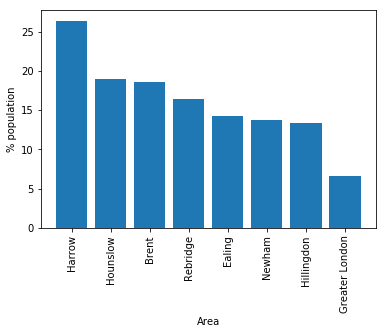

In [48]:
plt.bar(df4['Borough'],df4['Indian'])
plt.xticks( rotation = 90)
plt.xlabel('Area')
plt.ylabel('% population')

In [49]:
df_indian_top = df3[df3['Borough'].isin(['Harrow','Hounslow','Brent','Rebridge','Ealing','Newham','Hillington','Greater London','Barnet'])].reset_index(drop = True)

In [50]:
df_indian_top.head()

,Location,Borough,Postcode
0,Church End,Brent,NW10
1,Church End,Barnet,N3
2,Colindale,Barnet,NW9
3,Colney Hatch,Barnet,N11
4,Colney Hatch,Barnet,N10


In [51]:
def get_latlng(arcgis_geocoder):
    lat_lng_coords = None
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, London, United Kingdom'.format(arcgis_geocoder))
        lat_lng_coords = g.latlng
    return lat_lng_coords

In [52]:
sample = get_latlng('NW10')
sample

[51.53916000000004, -0.2512299999999641]

In [53]:
start = time.time()

postal_codes = df_indian_top['Postcode']    
coordinates = [get_latlng(postal_code) for postal_code in postal_codes.tolist()]

end = time.time()
print("Time of execution: ", end - start, "seconds")

Time of execution:  174.16168308258057 seconds


In [54]:
df_indian_loc = df_indian_top

df_indian_coordinates = pd.DataFrame(coordinates, columns = ['Latitude', 'Longitude'])
df_indian_loc['Latitude'] = df_indian_coordinates['Latitude']
df_indian_loc['Longitude'] = df_indian_coordinates['Longitude']

In [55]:
df_indian_loc.head()

,Location,Borough,Postcode,Latitude,Longitude
0,Church End,Brent,NW10,51.53916,-0.25123
1,Church End,Barnet,N3,51.60104,-0.19401
2,Colindale,Barnet,NW9,51.58486,-0.24881
3,Colney Hatch,Barnet,N11,51.61631,-0.13839
4,Colney Hatch,Barnet,N10,51.59107,-0.14852


In [56]:
df_indian_loc.to_csv('IndiaLondonLocationsCoordinates.csv', index = False)

In [57]:
df_indian_loc.shape

(71, 5)

In [58]:
#FourSquare Credentials
CLIENT_ID = 'KN0SRH2RHZ3HJRVQSH1BOQHLJ4ESYWSIC53QYCFXRQJSA5UW' # your Foursquare ID
CLIENT_SECRET = 'HBAAOTNXALQYM4JSCEJ1E2H4D3NXRNWGFU3IZG21UIDJIBHI' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: KN0SRH2RHZ3HJRVQSH1BOQHLJ4ESYWSIC53QYCFXRQJSA5UW
CLIENT_SECRET:HBAAOTNXALQYM4JSCEJ1E2H4D3NXRNWGFU3IZG21UIDJIBHI


In [59]:
def getNearbyVenues(names, latitudes, longitudes, radius=2000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [60]:
venues = getNearbyVenues(names=df_indian_loc['Location'],
                                   latitudes=df_indian_loc['Latitude'],
                                   longitudes=df_indian_loc['Longitude']
                                  )

Church End
Church End
Colindale
Colney Hatch
Colney Hatch
Custom House
Dollis Hill
Arkley
Arkley
Ealing
Ealing
East Finchley
East Ham
Finchley
Finchley
Finchley
Forest Gate
Friern Barnet
Golders Green
Grahame Park
Grove Park
Gunnersbury
The Hale
Hampstead Garden Suburb
Hanwell
Harlesden
Hendon
Barnet Gate
Barnet Gate
The Hyde
Kensal Green
Kensal Green
Kingsbury
Little Ilford
Manor Park
Beckton
Beckton
Beckton
Maryland
Mill Hill
Neasden
Neasden
New Southgate
North Finchley
Bedford Park
North Woolwich
Oakleigh Park
Osidge
Plaistow
Queen's Park
Silvertown
Stonebridge
Stratford
Totteridge
Upton Park
Upton Park
West Ealing
West Ham
West Ham
West Hendon
Whetstone
Willesden
Woodside Park
Brent Cross
Brent Cross
Brent Park
Brondesbury
Brunswick Park
Burroughs, The
Canning Town
Childs Hill


In [61]:
len(venues)

2122

In [62]:
venues['Neighbourhood'].value_counts()
venues.to_csv('venues.csv')

In [63]:
venues.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Church End,51.53916,-0.25123,Beit El Zaytoun,51.534330,-0.261639,Middle Eastern Restaurant
1,Church End,51.53916,-0.25123,Rubio,51.537217,-0.241696,Pizza Place
2,Church End,51.53916,-0.25123,Grand Junction Arms,51.534325,-0.260390,Pub
3,Church End,51.53916,-0.25123,Centro Galego,51.532234,-0.236863,Spanish Restaurant
4,Church End,51.53916,-0.25123,Behesht,51.531926,-0.232520,Persian Restaurant


In [64]:
venues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Arkley,58,58,58,58,58,58
Barnet Gate,58,58,58,58,58,58
Beckton,90,90,90,90,90,90
Bedford Park,30,30,30,30,30,30
Brent Cross,60,60,60,60,60,60
Brent Park,30,30,30,30,30,30
Brondesbury,30,30,30,30,30,30
Brunswick Park,30,30,30,30,30,30
"Burroughs, The",30,30,30,30,30,30


In [65]:
print('There are {} uniques categories.'.format(len(venues['Venue Category'].unique())))

There are 129 uniques categories.


In [66]:
venue_unique_count = venues['Venue Category'].value_counts().to_frame(name='Count')

In [67]:
venue_unique_count.head(7)

,Count
Coffee Shop,148
Park,139
Pub,126
Café,123
Indian Restaurant,84
Grocery Store,76
Hotel,67


In [68]:
venue_unique_count.describe()

,Count
count,129.000000
mean,16.449612
std,25.828449
min,1.000000
25%,4.000000
50%,8.000000
75%,17.000000
max,148.000000


# Plotting the Map of London

In [69]:
address = 'London, United Kingdom'

geolocator = Nominatim(user_agent="ln_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of London are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of London are 51.5073219, -0.1276474.


In [70]:
# df_london_map
map_london = folium.Map(location = [latitude, longitude], zoom_start = 12)
map_london

In [71]:
# Adding markers to map
for lat, lng, borough, loc in zip(df_indian_loc['Latitude'], 
                                  df_indian_loc['Longitude'],
                                  df_indian_loc['Borough'],
                                  df_indian_loc['Location']):
    label = '{} - {}'.format(loc, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_london)  
    
display(map_london)

In [72]:
onehot = pd.get_dummies(venues[['Venue Category']], prefix = "", prefix_sep = "")

In [73]:
onehot['Neighbourhood'] = venues['Neighbourhood']

In [74]:
onehot.head()

,Argentinian Restaurant,Art Gallery,Asian Restaurant,BBQ Joint,Bakery,Bar,Beer Bar,Bistro,Bookstore,Brasserie,...,Thai Restaurant,Theater,Toy / Game Store,Trail,Turkish Restaurant,Vietnamese Restaurant,Wine Bar,Wings Joint,Zoo,Neighbourhood
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Church End
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Church End
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Church End
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Church End
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Church End


In [75]:
fixed_columns = [onehot.columns[-1]] + list(onehot.columns[:-1])

onehot = onehot[fixed_columns]

In [76]:
onehot

,Neighbourhood,Argentinian Restaurant,Art Gallery,Asian Restaurant,BBQ Joint,Bakery,Bar,Beer Bar,Bistro,Bookstore,...,Tea Room,Thai Restaurant,Theater,Toy / Game Store,Trail,Turkish Restaurant,Vietnamese Restaurant,Wine Bar,Wings Joint,Zoo
0,Church End,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Church End,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Church End,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Church End,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Church End,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Church End,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,Church End,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,Church End,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,Church End,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,Church End,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [77]:
onehot.loc[onehot['Indian Restaurant'] != 0]

,Neighbourhood,Argentinian Restaurant,Art Gallery,Asian Restaurant,BBQ Joint,Bakery,Bar,Beer Bar,Bistro,Bookstore,...,Tea Room,Thai Restaurant,Theater,Toy / Game Store,Trail,Turkish Restaurant,Vietnamese Restaurant,Wine Bar,Wings Joint,Zoo
14,Church End,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26,Church End,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44,Church End,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
73,Colindale,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
93,Colney Hatch,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
134,Colney Hatch,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
222,Arkley,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
247,Arkley,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
331,East Finchley,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
336,East Finchley,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [78]:
onehot.loc[onehot['Neighbourhood'] == 'The Hale']

,Neighbourhood,Argentinian Restaurant,Art Gallery,Asian Restaurant,BBQ Joint,Bakery,Bar,Beer Bar,Bistro,Bookstore,...,Tea Room,Thai Restaurant,Theater,Toy / Game Store,Trail,Turkish Restaurant,Vietnamese Restaurant,Wine Bar,Wings Joint,Zoo
658,The Hale,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
659,The Hale,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
660,The Hale,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
661,The Hale,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
662,The Hale,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
663,The Hale,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
664,The Hale,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
665,The Hale,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
666,The Hale,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
667,The Hale,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


As can be seen from above, THE HALE with its demography has only 1 Indian Restaurant

In [79]:
onehot.to_csv('london_onehot.csv', index = False)

In [80]:
onehot.shape

(2122, 130)

In [81]:
grouped = onehot.groupby('Neighbourhood').mean().reset_index()
grouped.head()

,Neighbourhood,Argentinian Restaurant,Art Gallery,Asian Restaurant,BBQ Joint,Bakery,Bar,Beer Bar,Bistro,Bookstore,...,Tea Room,Thai Restaurant,Theater,Toy / Game Store,Trail,Turkish Restaurant,Vietnamese Restaurant,Wine Bar,Wings Joint,Zoo
0,Arkley,0.017241,0.000000,0.017241,0.000000,0.034483,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0
1,Barnet Gate,0.017241,0.000000,0.017241,0.000000,0.034483,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0
2,Beckton,0.011111,0.011111,0.011111,0.000000,0.011111,0.022222,0.0,0.0,0.000000,...,0.0,0.011111,0.0,0.022222,0.000000,0.0,0.0,0.000000,0.0,0.0
3,Bedford Park,0.033333,0.000000,0.000000,0.000000,0.066667,0.033333,0.0,0.0,0.033333,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.033333,0.0,0.0
4,Brent Cross,0.000000,0.000000,0.000000,0.016667,0.033333,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.016667,0.0,0.0,0.000000,0.0,0.0


In [82]:
print("Before One-hot encoding:",df_indian_loc.shape)
print("After One-hot encoding:", grouped.shape)

Before One-hot encoding: (71, 5)
After One-hot encoding: (57, 130)


In [83]:
grouped.to_csv('london_grouped.csv', index = False)

Grouping of each Neighbourhoods with 10 common venues:

In [84]:
num_top_venues = 10

for hood in grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = grouped[grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue', 'freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending = False).reset_index(drop = True).head(num_top_venues))
    print('\n')

----Arkley----
                venue  freq
0       Grocery Store  0.10
1         Coffee Shop  0.10
2                 Pub  0.09
3  Italian Restaurant  0.09
4                Café  0.05
5                Park  0.05
6         Pizza Place  0.03
7            Pharmacy  0.03
8   Indian Restaurant  0.03
9              Bakery  0.03


----Barnet Gate----
                venue  freq
0       Grocery Store  0.10
1         Coffee Shop  0.10
2                 Pub  0.09
3  Italian Restaurant  0.09
4                Café  0.05
5                Park  0.05
6         Pizza Place  0.03
7            Pharmacy  0.03
8   Indian Restaurant  0.03
9              Bakery  0.03


----Beckton----
                    venue  freq
0             Coffee Shop  0.09
1                    Park  0.07
2       Indian Restaurant  0.07
3                   Hotel  0.06
4             Supermarket  0.04
5                     Pub  0.04
6  Furniture / Home Store  0.03
7          Discount Store  0.03
8                     Gym  0.03
9        

                venue  freq
0         Coffee Shop  0.13
1                Café  0.10
2              Forest  0.07
3   Indian Restaurant  0.07
4                 Pub  0.07
5       Deli / Bodega  0.07
6   French Restaurant  0.07
7  Italian Restaurant  0.07
8   Food & Drink Shop  0.03
9          Playground  0.03


----Hanwell----
                    venue  freq
0                    Park  0.17
1                   Hotel  0.10
2                     Pub  0.10
3                 Brewery  0.07
4                    Café  0.07
5  Furniture / Home Store  0.03
6       Fish & Chips Shop  0.03
7          Farmers Market  0.03
8           Grocery Store  0.03
9                     Gym  0.03


----Harlesden----
                       venue  freq
0  Middle Eastern Restaurant  0.10
1                 Hookah Bar  0.07
2              Movie Theater  0.07
3                       Café  0.07
4                        Pub  0.07
5                Coffee Shop  0.07
6          Indian Restaurant  0.07
7              Grocery

9        Toy / Game Store  0.03


----West Ealing----
                  venue  freq
0                   Pub  0.13
1           Coffee Shop  0.10
2                  Park  0.07
3           Pizza Place  0.07
4                 Hotel  0.07
5          Burger Joint  0.03
6          Noodle House  0.03
7           Supermarket  0.03
8         Grocery Store  0.03
9  Caribbean Restaurant  0.03


----West Ham----
                  venue  freq
0                  Park  0.08
1                  Café  0.07
2                   Pub  0.05
3           Coffee Shop  0.05
4      Toy / Game Store  0.03
5        Ice Cream Shop  0.03
6        Clothing Store  0.03
7         Grocery Store  0.03
8  Gym / Fitness Center  0.03
9    Turkish Restaurant  0.03


----West Hendon----
                  venue  freq
0  Gym / Fitness Center  0.10
1                 Hotel  0.07
2                  Park  0.07
3                   Pub  0.07
4           Supermarket  0.07
5             Pet Store  0.07
6         Garden Center  0.03
7    

In [85]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending = False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [86]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = grouped['Neighbourhood']

for ind in np.arange(grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(grouped.iloc[ind, :], num_top_venues)

In [87]:
neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Arkley,Coffee Shop,Grocery Store,Pub,Italian Restaurant,Café,Park,Bakery,Pizza Place,Pharmacy,Golf Course
1,Barnet Gate,Coffee Shop,Grocery Store,Pub,Italian Restaurant,Café,Park,Bakery,Pizza Place,Pharmacy,Golf Course
2,Beckton,Coffee Shop,Indian Restaurant,Park,Hotel,Pub,Supermarket,Gym,Furniture / Home Store,Discount Store,Pharmacy
3,Bedford Park,Coffee Shop,Café,Ice Cream Shop,Bakery,Hotel,Japanese Restaurant,Historic Site,Grocery Store,Mediterranean Restaurant,French Restaurant
4,Brent Cross,Park,Grocery Store,Café,Department Store,Burger Joint,Portuguese Restaurant,Snack Place,Korean Restaurant,Pub,Sushi Restaurant


In [88]:
neighbourhoods_venues_sorted.to_csv('neighbourhoods_venues_sorted.csv', index = False)

In [89]:
grouped_clustering = grouped.drop('Neighbourhood', 1)

# CLUSTERING

The next thing to do now, is to create clusters of the neighbourhood using the k-means to cluster the neighbourhood into 5 clusters.

In [90]:
kclusters = 5

kmeans = KMeans(n_clusters = kclusters, random_state=0).fit(grouped_clustering)

kmeans.labels_[0:10]

array([4, 4, 2, 2, 1, 2, 2, 4, 1, 3])

In [91]:
kmeans.labels_[0:10]

array([4, 4, 2, 2, 1, 2, 2, 4, 1, 3])

Now creating a new dataframe that includes the clusters as well as the top 10 venues for each neighbourhoods.

In [92]:
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [93]:
merged = df_indian_loc

In [94]:
merged.head()

,Location,Borough,Postcode,Latitude,Longitude
0,Church End,Brent,NW10,51.53916,-0.25123
1,Church End,Barnet,N3,51.60104,-0.19401
2,Colindale,Barnet,NW9,51.58486,-0.24881
3,Colney Hatch,Barnet,N11,51.61631,-0.13839
4,Colney Hatch,Barnet,N10,51.59107,-0.14852


In [95]:
merged_latlong = merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on = 'Location')

In [96]:
merged_latlong.head(5)

,Location,Borough,Postcode,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Church End,Brent,NW10,51.53916,-0.25123,2,Café,Middle Eastern Restaurant,Turkish Restaurant,Coffee Shop,Park,Indian Restaurant,Supermarket,Pub,Grocery Store,Hookah Bar
1,Church End,Barnet,N3,51.60104,-0.19401,2,Café,Middle Eastern Restaurant,Turkish Restaurant,Coffee Shop,Park,Indian Restaurant,Supermarket,Pub,Grocery Store,Hookah Bar
2,Colindale,Barnet,NW9,51.58486,-0.24881,1,Gym / Fitness Center,Pub,Supermarket,Pet Store,Park,Hotel,Pizza Place,Indian Restaurant,Portuguese Restaurant,Café
3,Colney Hatch,Barnet,N11,51.61631,-0.13839,4,Café,Coffee Shop,Park,Bakery,Forest,Pub,Dessert Shop,Gym / Fitness Center,Indian Restaurant,Pizza Place
4,Colney Hatch,Barnet,N10,51.59107,-0.14852,4,Café,Coffee Shop,Park,Bakery,Forest,Pub,Dessert Shop,Gym / Fitness Center,Indian Restaurant,Pizza Place


In [97]:
clusters = merged_latlong

Number clusters = 5, is chosen for initial run

To get the optimal number of clusters to be used for the K-mean, there are a number ways possible for the evaluation. Therefore, in this task, the following are used:

__1. ELBOW METHOD__
The Elbow method is a method of interpretation and validation of consistency within cluster analysis designed to help finding the appropriate number of clusters in a dataset.

The approach for this is to run the k-means clustering for a range of value k and for each value of k, the Sum of the Squared Errors (SSE) is calculated., calculate sum of squared errors (SSE). When this is done, a plot of k and the corresponding SSEs are then made. At the elbow (just like arm), that is where the optimal value of k is. And that will be the number of clusters to be used. The whole idea is to have minimum SSE.

In [98]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [99]:
from sklearn.preprocessing import MinMaxScaler

In [100]:
data = pd.read_csv('london_grouped.csv')
data.head()

,Neighbourhood,Argentinian Restaurant,Art Gallery,Asian Restaurant,BBQ Joint,Bakery,Bar,Beer Bar,Bistro,Bookstore,...,Tea Room,Thai Restaurant,Theater,Toy / Game Store,Trail,Turkish Restaurant,Vietnamese Restaurant,Wine Bar,Wings Joint,Zoo
0,Arkley,0.017241,0.000000,0.017241,0.000000,0.034483,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0
1,Barnet Gate,0.017241,0.000000,0.017241,0.000000,0.034483,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0
2,Beckton,0.011111,0.011111,0.011111,0.000000,0.011111,0.022222,0.0,0.0,0.000000,...,0.0,0.011111,0.0,0.022222,0.000000,0.0,0.0,0.000000,0.0,0.0
3,Bedford Park,0.033333,0.000000,0.000000,0.000000,0.066667,0.033333,0.0,0.0,0.033333,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.033333,0.0,0.0
4,Brent Cross,0.000000,0.000000,0.000000,0.016667,0.033333,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.016667,0.0,0.0,0.000000,0.0,0.0


In [101]:
categorical_features = ['Neighbourhood']
continous_features = ['Indian Restaurant','Korean Restaurant','Thai Restaurant','Japanese Restaurant','Persian Restaurant','Middle Eastern Restaurant','Noodle House']

In [102]:
categorical_features = ['Neighbourhood']
continous_features = ['Indian Restaurant','Middle Eastern Restaurant','Noodle House']

In [103]:
data[continous_features].describe()

,Indian Restaurant,Middle Eastern Restaurant,Noodle House
count,57.000000,57.000000,57.000000
mean,0.039013,0.014815,0.001170
std,0.046421,0.029887,0.006188
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.033333,0.000000,0.000000
75%,0.035714,0.000000,0.000000
max,0.200000,0.100000,0.033333


In [104]:
for col in categorical_features:
    dummies = pd.get_dummies(data[col], prefix=col)
    data = pd.concat([data, dummies], axis=1)
    data.drop(col, axis=1, inplace=True)

In [105]:
data.head()

,Argentinian Restaurant,Art Gallery,Asian Restaurant,BBQ Joint,Bakery,Bar,Beer Bar,Bistro,Bookstore,Brasserie,...,Neighbourhood_The Hale,Neighbourhood_The Hyde,Neighbourhood_Totteridge,Neighbourhood_Upton Park,Neighbourhood_West Ealing,Neighbourhood_West Ham,Neighbourhood_West Hendon,Neighbourhood_Whetstone,Neighbourhood_Willesden,Neighbourhood_Woodside Park
0,0.017241,0.000000,0.017241,0.000000,0.034483,0.000000,0.0,0.0,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
1,0.017241,0.000000,0.017241,0.000000,0.034483,0.000000,0.0,0.0,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
2,0.011111,0.011111,0.011111,0.000000,0.011111,0.022222,0.0,0.0,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
3,0.033333,0.000000,0.000000,0.000000,0.066667,0.033333,0.0,0.0,0.033333,0.033333,...,0,0,0,0,0,0,0,0,0,0
4,0.000000,0.000000,0.000000,0.016667,0.033333,0.000000,0.0,0.0,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0


In [106]:
mms = MinMaxScaler()
mms.fit(data)
data_transformed = mms.transform(data)

C:\Users\Harshvardhan Khidiya\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [107]:
Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(data_transformed)
    Sum_of_squared_distances.append(km.inertia_)

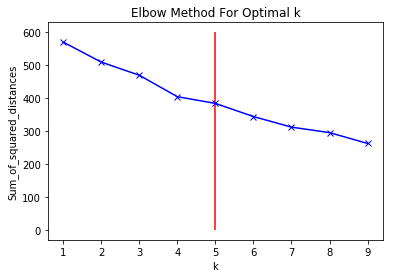

In [108]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.vlines(5, ymin = 0, ymax = 600, colors = 'red')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

the number of cluster, k is 5.

__2. SILHOUTE COEFFICIENT__
To find the optimal value of the number of clusters, k, the number of clusters is iterated corresponding Silhouette Coefficientis calculated for each of the k-values used. The highest Silhouette Coefficient gives the best match to its own cluster. Please see below:

In [109]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

for n_cluster2 in range(2,6):
    kmeans2 = KMeans(n_clusters = n_cluster2, random_state = 0).fit(grouped_clustering)
    label2 = kmeans2.labels_
    sil_coeff = silhouette_score(grouped_clustering, label2, metric = 'euclidean')
    print("Where n_clusters = {}, the Silhouette Coefficient is {}".format(n_cluster2, sil_coeff))

Where n_clusters = 2, the Silhouette Coefficient is 0.23852617780976593
Where n_clusters = 3, the Silhouette Coefficient is 0.20017942592733934
Where n_clusters = 4, the Silhouette Coefficient is 0.22712719112101407
Where n_clusters = 5, the Silhouette Coefficient is 0.2249459715162582


In [110]:
clusters.columns

Index(['Location', 'Borough', 'Postcode', 'Latitude', 'Longitude',
       'Cluster Labels', '1st Most Common Venue', '2nd Most Common Venue',
       '3rd Most Common Venue', '4th Most Common Venue',
       '5th Most Common Venue', '6th Most Common Venue',
       '7th Most Common Venue', '8th Most Common Venue',
       '9th Most Common Venue', '10th Most Common Venue'],
      dtype='object')

In [111]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(clusters['Latitude'], clusters['Longitude'], clusters['Location'], clusters['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=20,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

display(map_clusters)

__CLUSTER 1__

In [112]:
clusters.loc[clusters['Cluster Labels'] == 0, clusters.columns[[1] + list(range(5, clusters.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,Newham,0,Indian Restaurant,Park,Pub,Coffee Shop,Furniture / Home Store,Grocery Store,Fast Food Restaurant,Fish & Chips Shop,Discount Store,Sandwich Place
16,Newham,0,Pub,Indian Restaurant,Park,Bar,Restaurant,Café,Indie Theater,Grocery Store,Doner Restaurant,Indie Movie Theater
33,Newham,0,Indian Restaurant,Coffee Shop,Furniture / Home Store,Park,Pub,Department Store,Café,Irish Pub,Ice Cream Shop,Gym / Fitness Center
34,Newham,0,Indian Restaurant,Coffee Shop,Furniture / Home Store,Park,Pub,Department Store,Café,Irish Pub,Ice Cream Shop,Gym / Fitness Center
54,Newham,0,Indian Restaurant,Coffee Shop,Pub,Park,Café,Supermarket,Fast Food Restaurant,Grocery Store,Gym,Shopping Mall
55,Newham,0,Indian Restaurant,Coffee Shop,Pub,Park,Café,Supermarket,Fast Food Restaurant,Grocery Store,Gym,Shopping Mall


## CLUSTER 2

In [113]:
clusters.loc[clusters['Cluster Labels'] == 1, clusters.columns[[1] + list(range(5, clusters.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Barnet,1,Gym / Fitness Center,Pub,Supermarket,Pet Store,Park,Hotel,Pizza Place,Indian Restaurant,Portuguese Restaurant,Café
6,Brent,1,Park,Grocery Store,Café,Burger Joint,Portuguese Restaurant,Deli / Bodega,Sandwich Place,Coffee Shop,Clothing Store,Pub
18,Barnet,1,Grocery Store,Park,Bakery,Italian Restaurant,Turkish Restaurant,Korean Restaurant,Sushi Restaurant,Zoo,Pub,Coffee Shop
19,Barnet,1,Gym / Fitness Center,Pub,Supermarket,Pet Store,Park,Hotel,Pizza Place,Indian Restaurant,Portuguese Restaurant,Café
22,Barnet,1,Italian Restaurant,Grocery Store,Pub,Golf Course,History Museum,Pizza Place,Pharmacy,Park,Indian Restaurant,Hotel
26,Barnet,1,Department Store,History Museum,Park,Grocery Store,Spa,Pizza Place,Hotel,Portuguese Restaurant,Pub,Restaurant
29,Barnet,1,Gym / Fitness Center,Pub,Supermarket,Pet Store,Park,Hotel,Pizza Place,Indian Restaurant,Portuguese Restaurant,Café
32,Brent,1,Gym / Fitness Center,Pub,Supermarket,Pet Store,Park,Hotel,Pizza Place,Indian Restaurant,Portuguese Restaurant,Café
38,Newham,1,Park,Café,Clothing Store,Sandwich Place,Department Store,Dessert Shop,Pub,Doner Restaurant,Electronics Store,Fish & Chips Shop
39,Barnet,1,Italian Restaurant,Grocery Store,Pub,Golf Course,History Museum,Pizza Place,Pharmacy,Park,Indian Restaurant,Hotel


### CLUSTER 3

In [114]:
clusters.loc[clusters['Cluster Labels'] == 2, clusters.columns[[1] + list(range(5, clusters.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Brent,2,Café,Middle Eastern Restaurant,Turkish Restaurant,Coffee Shop,Park,Indian Restaurant,Supermarket,Pub,Grocery Store,Hookah Bar
1,Barnet,2,Café,Middle Eastern Restaurant,Turkish Restaurant,Coffee Shop,Park,Indian Restaurant,Supermarket,Pub,Grocery Store,Hookah Bar
9,Ealing,2,Pub,Coffee Shop,Pizza Place,Park,Hotel,Burger Joint,Theater,Bakery,Salad Place,Bistro
10,Ealing,2,Pub,Coffee Shop,Pizza Place,Park,Hotel,Burger Joint,Theater,Bakery,Salad Place,Bistro
13,Barnet,2,Coffee Shop,Café,Turkish Restaurant,Park,Pub,Italian Restaurant,Middle Eastern Restaurant,Portuguese Restaurant,Indian Restaurant,Supermarket
14,Barnet,2,Coffee Shop,Café,Turkish Restaurant,Park,Pub,Italian Restaurant,Middle Eastern Restaurant,Portuguese Restaurant,Indian Restaurant,Supermarket
15,Barnet,2,Coffee Shop,Café,Turkish Restaurant,Park,Pub,Italian Restaurant,Middle Eastern Restaurant,Portuguese Restaurant,Indian Restaurant,Supermarket
20,Hounslow,2,Coffee Shop,Café,Ice Cream Shop,Bakery,Hotel,Japanese Restaurant,Historic Site,Grocery Store,Mediterranean Restaurant,French Restaurant
21,Hounslow,2,Coffee Shop,Café,Ice Cream Shop,Bakery,Hotel,Japanese Restaurant,Historic Site,Grocery Store,Mediterranean Restaurant,French Restaurant
24,Ealing,2,Park,Pub,Hotel,Brewery,Café,Persian Restaurant,Doner Restaurant,Diner,Furniture / Home Store,Deli / Bodega


### CLUSTER 4

In [115]:
clusters.loc[clusters['Cluster Labels'] == 3, clusters.columns[[1] + list(range(5, clusters.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Newham,3,Hotel,Coffee Shop,Bar,Park,Scenic Lookout,Italian Restaurant,Gym,Lighthouse,Lounge,Golf Driving Range
45,Newham,3,Hotel,Coffee Shop,Bar,Park,Scenic Lookout,Italian Restaurant,Gym,Lighthouse,Lounge,Golf Driving Range
50,Newham,3,Hotel,Coffee Shop,Bar,Park,Scenic Lookout,Italian Restaurant,Gym,Lighthouse,Lounge,Golf Driving Range
69,Newham,3,Hotel,Coffee Shop,Bar,Park,Scenic Lookout,Italian Restaurant,Gym,Lighthouse,Lounge,Golf Driving Range


### CLUSTER 5

In [116]:
clusters.loc[clusters['Cluster Labels'] == 4, clusters.columns[[1] + list(range(5, clusters.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Barnet,4,Café,Coffee Shop,Park,Bakery,Forest,Pub,Dessert Shop,Gym / Fitness Center,Indian Restaurant,Pizza Place
4,Barnet,4,Café,Coffee Shop,Park,Bakery,Forest,Pub,Dessert Shop,Gym / Fitness Center,Indian Restaurant,Pizza Place
7,Barnet,4,Coffee Shop,Grocery Store,Pub,Italian Restaurant,Café,Park,Bakery,Pizza Place,Pharmacy,Golf Course
8,Barnet,4,Coffee Shop,Grocery Store,Pub,Italian Restaurant,Café,Park,Bakery,Pizza Place,Pharmacy,Golf Course
11,Barnet,4,Coffee Shop,Café,Indian Restaurant,Italian Restaurant,Pub,Forest,French Restaurant,Deli / Bodega,Mediterranean Restaurant,Food & Drink Shop
17,Barnet,4,Café,Coffee Shop,Italian Restaurant,Park,Pub,Dessert Shop,Greek Restaurant,Indian Restaurant,Grocery Store,Pizza Place
23,Barnet,4,Coffee Shop,Café,Indian Restaurant,Italian Restaurant,Pub,Forest,French Restaurant,Deli / Bodega,Mediterranean Restaurant,Food & Drink Shop
27,Barnet,4,Coffee Shop,Grocery Store,Pub,Italian Restaurant,Café,Park,Bakery,Pizza Place,Pharmacy,Golf Course
28,Barnet,4,Coffee Shop,Grocery Store,Pub,Italian Restaurant,Café,Park,Bakery,Pizza Place,Pharmacy,Golf Course
42,Barnet,4,Café,Coffee Shop,Italian Restaurant,Park,Pub,Dessert Shop,Greek Restaurant,Indian Restaurant,Grocery Store,Pizza Place


# 4. RESULT

__HIGHLIGHTS FROM ABOVE 5 CLUSTERS__

1. Pubs, Cafe, Coffee Shops are popular in the London.
2. As for restaurants, the Italian Restaurants are very popular in the  London.
3. Although, the Clusters have variations, a very visible presence is the dominance of pubs.

_We conclude from above observation that CLUSTERS 3 and 5 are scarce in terms of availability of INDIAN RESTAURANTS_

Hence, above two mentioned clusters are suitable for opening a new INDIAN RESTAURANT

# 5. DISCUSSION AND CONCLUSION

It is very important to note that Clusters 3 and 5 are the most viable clusters to create a __INDIAN RESTAURANT__. Their proximity to other amenities and accessibility to INDIAN PEOPLE are paramount. These 2 _clusters do not have top restaurants that could rival their standards_ if they are created.

In conclusion, this project would have had better results if there were more data in terms of crime data within the area, traffic access and allowance of more venues exploration with the Foursquare (limited venues for free calls).

Also, getting the ratings and feedbacks of the current restaurants within the clusters would have helped in providing more insight into the best location.